# Erhan Asad Javed

## Pricing & Affordability Trends in NYC

#### What factors determine the price of an Airbnb listing in NYC?


#### Key research questions:
- How does room type impact price variations?
- What is the effect of location (neighborhood group, latitude, and longitude) on price differences?
- Does the host's listing count or years of hosting (host_since) influence listing prices?
- How do reviews per month, review scores, and the total number of reviews correlate with pricing?
- What role does availability over 365 days and minimum nights play in pricing strategies?

## EDA

### Imports

In [1]:
import os

import altair as alt
import pandas as pd
from toolz.curried import pipe
import numpy as np
import sys

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

sys.path.append(os.path.abspath("../../code"))
from cleaning_workflows import prepare_dataset

### Loading in the data

In [2]:
df = pd.read_csv('../../data/raw/listings.csv', parse_dates=['first_review', 'last_review'])

df.head()


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39572,https://www.airbnb.com/rooms/39572,20250103033441,2025-01-03,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,https://a0.muscache.com/pictures/fd1bffd9-ccf8...,169927,...,5.00,4.98,4.86,NaN,f,2,1,1,0,0.25
1,39593,https://www.airbnb.com/rooms/39593,20250103033441,2025-01-03,city scrape,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",https://a0.muscache.com/pictures/0b9110f7-3b24...,110506,...,4.96,4.79,4.93,NaN,f,1,0,1,0,0.20
2,39704,https://www.airbnb.com/rooms/39704,20250103033441,2025-01-03,previous scrape,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,https://a0.muscache.com/pictures/0bc4e8a4-c047...,170510,...,4.92,4.38,4.72,NaN,f,2,2,0,0,1.93
3,42300,https://www.airbnb.com/rooms/42300,20250103033441,2025-01-03,city scrape,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",https://a0.muscache.com/pictures/0e285e13-ee14...,184755,...,4.87,4.57,4.62,NaN,f,1,1,0,0,0.40
4,42729,https://www.airbnb.com/rooms/42729,20250103033441,2025-01-03,city scrape,@HouseOnHenrySt - Private 2nd bedroom w/shared...,NaN,"Lovely old Brooklyn neighborhood, with brick/b...",https://a0.muscache.com/pictures/925fe213-f5e1...,11481,...,4.73,4.58,4.64,NaN,f,4,1,3,0,1.26


In [3]:
# Make a copy of the dataset
df_cleaned = df.copy()

# Drop columns with mostly missing values
df_cleaned.drop(columns=["calendar_updated", "license"], inplace=True)

# Fill missing values for categorical variables
categorical_fill_values = {
    "name": "Unknown",
    "description": "No description available",
    "neighborhood_overview": "No overview available",
    "host_name": "Unknown",
    "host_location": "Not provided",
    "host_response_time": "No response time",
    "host_is_superhost": "f",
    "has_availability": "f",
    "instant_bookable": "f"
}
df_cleaned.fillna(value=categorical_fill_values, inplace=True)

# Convert date columns
date_cols = ["host_since", "last_scraped", "first_review", "last_review", "calendar_last_scraped"]
for col in date_cols:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors="coerce")
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Convert percentage columns to numeric
percentage_cols = ["host_response_rate", "host_acceptance_rate"]
for col in percentage_cols:
    df_cleaned[col] = df_cleaned[col].str.replace("%", "").astype(float) / 100
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

# Convert price column to numeric and fill
df_cleaned["price"] = df_cleaned["price"].str.replace("[\$,]", "", regex=True).astype(float)
df_cleaned["price"].fillna(df_cleaned["price"].median(), inplace=True)

# Fill missing numerical values with median
numerical_cols = df_cleaned.select_dtypes(include=["number"]).columns.tolist()
for col in numerical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

# Fill missing values in categorical columns with the most common value
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])

# Strip leading/trailing spaces from string columns
df_cleaned = df_cleaned.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

<>:34: SyntaxWarning: invalid escape sequence '\$'
<>:34: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_946/1101725020.py:34: SyntaxWarning: invalid escape sequence '\$'
  df_cleaned["price"] = df_cleaned["price"].str.replace("[\$,]", "", regex=True).astype(float)
/tmp/ipykernel_946/1101725020.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
/tmp/ipykernel_946/1101725020.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or

In [4]:
df_cleaned.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39572,https://www.airbnb.com/rooms/39572,20250103033441,2025-01-03,city scrape,1 br in a 2 br apt (Midtown West),No description available,No overview available,https://a0.muscache.com/pictures/fd1bffd9-ccf8...,169927,...,4.98,5.00,4.98,4.86,f,2,1,1,0,0.25
1,39593,https://www.airbnb.com/rooms/39593,20250103033441,2025-01-03,city scrape,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",https://a0.muscache.com/pictures/0b9110f7-3b24...,110506,...,4.96,4.96,4.79,4.93,f,1,0,1,0,0.20
2,39704,https://www.airbnb.com/rooms/39704,20250103033441,2025-01-03,previous scrape,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,https://a0.muscache.com/pictures/0bc4e8a4-c047...,170510,...,4.89,4.92,4.38,4.72,f,2,2,0,0,1.93
3,42300,https://www.airbnb.com/rooms/42300,20250103033441,2025-01-03,city scrape,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",https://a0.muscache.com/pictures/0e285e13-ee14...,184755,...,4.85,4.87,4.57,4.62,f,1,1,0,0,0.40
4,42729,https://www.airbnb.com/rooms/42729,20250103033441,2025-01-03,city scrape,@HouseOnHenrySt - Private 2nd bedroom w/shared...,No description available,"Lovely old Brooklyn neighborhood, with brick/b...",https://a0.muscache.com/pictures/925fe213-f5e1...,11481,...,4.71,4.73,4.58,4.64,f,4,1,3,0,1.26


In [5]:
print(df_cleaned.shape)
print(df_cleaned.columns)

(37784, 73)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_a

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            37784 non-null  int64         
 1   listing_url                                   37784 non-null  object        
 2   scrape_id                                     37784 non-null  int64         
 3   last_scraped                                  37784 non-null  datetime64[ns]
 4   source                                        37784 non-null  object        
 5   name                                          37784 non-null  object        
 6   description                                   37784 non-null  object        
 7   neighborhood_overview                         37784 non-null  object        
 8   picture_url                                   37784 non-null  obje

In [7]:
df_cleaned.isna().sum()

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
source                                          0
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 73, dtype: int64

In [8]:
numerical_cols = [col for col in numerical_cols if col not in ["id", "host_id"]]
print(numerical_cols)

['scrape_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [9]:
object_cols = df_cleaned.select_dtypes(include=['object']).columns
print(object_cols)

Index(['listing_url', 'source', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_url', 'host_name', 'host_location', 'host_about',
       'host_response_time', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'bathrooms_text', 'amenities',
       'has_availability', 'instant_bookable'],
      dtype='object')


In [10]:
df_cleaned.describe().drop(columns=['id', 'latitude', 'longitude', 'host_id'])

,scrape_id,last_scraped,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.778400e+04,37784,37784,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,...,37784.00000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000
mean,2.025010e+13,2025-01-03 00:00:00,2017-03-06 09:48:26.373067776,0.952508,0.812859,263.096326,351.484568,2.754896,1.196693,1.380172,...,4.65604,4.833322,4.825059,4.741406,4.637652,71.636354,45.435555,23.985232,0.005187,0.866954
min,2.025010e+13,2025-01-03 00:00:00,2008-08-11 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.025010e+13,2025-01-03 00:00:00,2014-07-07 00:00:00,1.000000,0.840000,1.000000,1.000000,2.000000,1.000000,1.000000,...,4.65604,4.833322,4.825059,4.741406,4.637652,1.000000,0.000000,0.000000,0.000000,0.160000
50%,2.025010e+13,2025-01-03 00:00:00,2016-08-02 00:00:00,1.000000,0.880000,2.000000,3.000000,2.000000,1.196693,1.000000,...,4.65604,4.833322,4.830000,4.741406,4.637652,2.000000,1.000000,1.000000,0.000000,0.866954
75%,2.025010e+13,2025-01-03 00:00:00,2019-10-29 00:00:00,1.000000,0.950000,10.000000,15.000000,4.000000,1.196693,1.380172,...,4.91000,5.000000,5.000000,4.950000,4.850000,9.000000,2.000000,2.000000,0.000000,0.866954
max,2.025010e+13,2025-01-03 00:00:00,2024-12-27 00:00:00,1.000000,1.000000,5079.000000,9048.000000,16.000000,15.500000,16.000000,...,5.00000,5.000000,5.000000,5.000000,5.000000,1154.000000,1154.000000,739.000000,4.000000,116.300000
std,1.895728e+01,NaN,NaN,0.173547,0.232501,1000.355666,1196.807939,1.903900,0.431695,0.859112,...,0.41723,0.312746,0.339608,0.327320,0.409641,224.585038,200.899492,109.136674,0.086848,1.561204


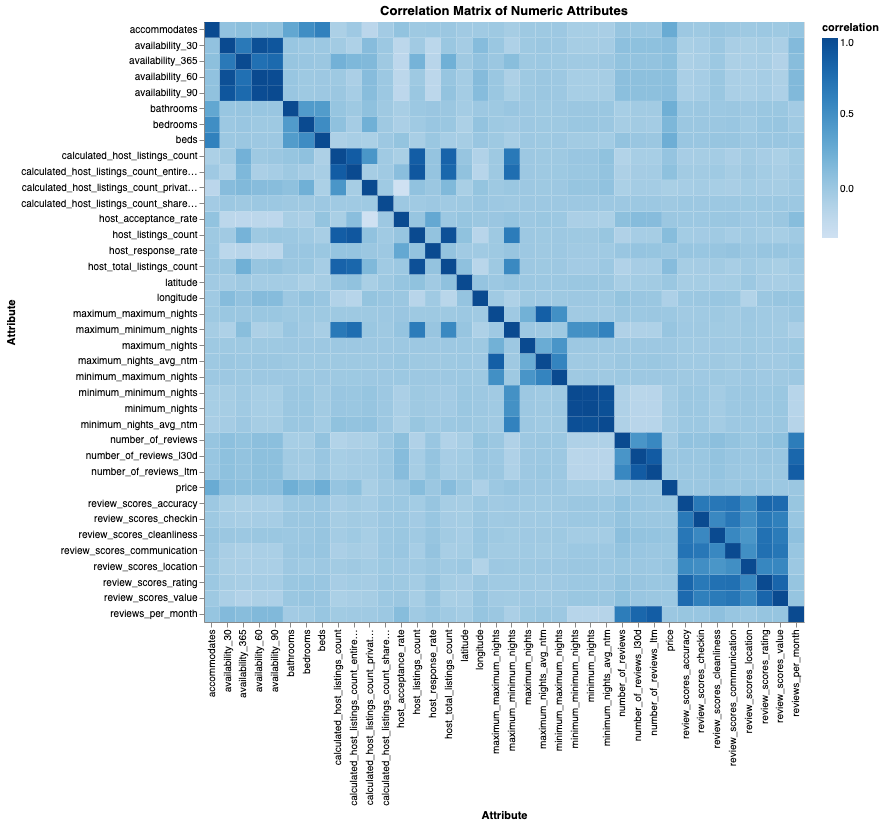

In [11]:
# Compute correlation matrix
correlation_matrix = df_cleaned[numerical_cols].corr().reset_index().melt(id_vars=["index"], var_name="variable", value_name="correlation")

# Create Altair heatmap
heatmap = alt.Chart(correlation_matrix).mark_rect().encode(
    x=alt.X("index:N", title="Attribute"),
    y=alt.Y("variable:N", title="Attribute"),
    color=alt.Color("correlation:Q", scale=alt.Scale(scheme="blues")),
    tooltip=["index", "variable", "correlation"]
).properties(
    title="Correlation Matrix of Numeric Attributes",
    width=600,
    height=600
)

# Display visualization
heatmap

#### Some basic visualizations

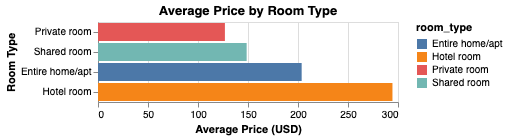

In [19]:
room_type_bar = alt.Chart(df_cleaned).mark_bar().encode(
    y=alt.Y("room_type:N", title="Room Type", sort = "x"),
    x=alt.X("mean(price):Q", title="Average Price (USD)"),
    color="room_type:N"
).properties(title="Average Price by Room Type")

room_type_bar


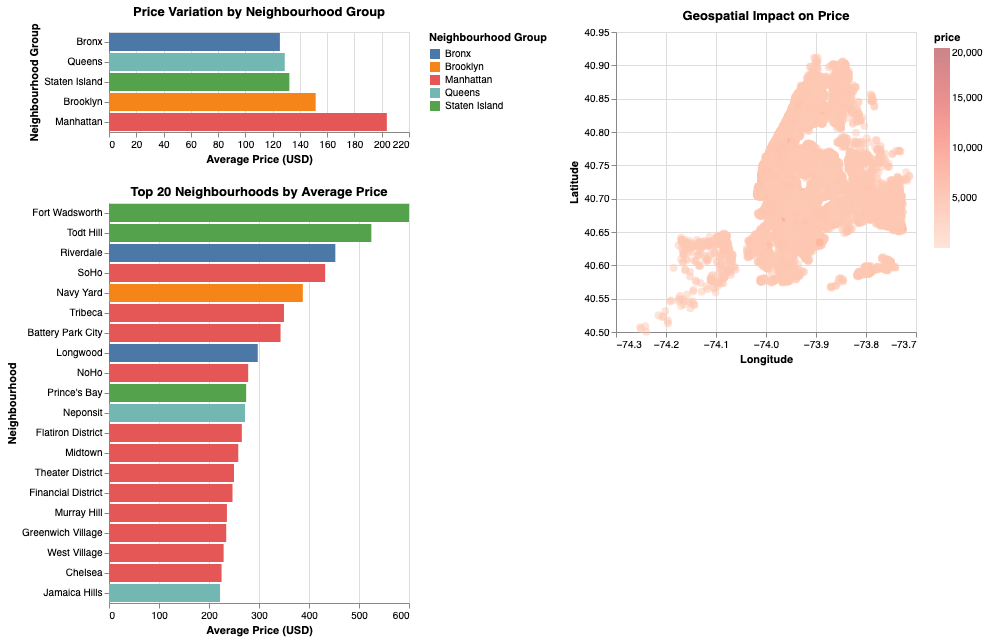

In [23]:
# Latitude, Longitude and Price
geo_chart = alt.Chart(df_cleaned).mark_circle(size=60, opacity=0.5).encode(
    x=alt.X("longitude:Q", title="Longitude", scale=alt.Scale(zero=False)),
    y=alt.Y("latitude:Q", title="Latitude", scale=alt.Scale(zero=False)),
    color=alt.Color("price:Q", scale=alt.Scale(scheme="reds")),
    tooltip=["latitude", "longitude", "price"]
).properties(title="Geospatial Impact on Price")

geo_bar = alt.Chart(df_cleaned).mark_bar().encode(
    y=alt.Y("neighbourhood_group_cleansed:N", title="Neighbourhood Group", sort = "x"),
    x=alt.X("mean(price):Q", title="Average Price (USD)"),
    color="neighbourhood_group_cleansed:N"
).properties(title="Price Variation by Neighbourhood Group")

top_neighbourhoods = df_cleaned.groupby(["neighbourhood_cleansed", "neighbourhood_group_cleansed"])["price"].mean().nlargest(20).reset_index()
top_neighbourhoods_chart = alt.Chart(top_neighbourhoods).mark_bar().encode(
    y=alt.Y("neighbourhood_cleansed:N", title="Neighbourhood", sort="-x"),
    x=alt.X("price:Q", title="Average Price (USD)"),
    color=alt.Color("neighbourhood_group_cleansed:N", legend=alt.Legend(title="Neighbourhood Group")),
    tooltip=["neighbourhood_cleansed", "price"]
).properties(title="Top 20 Neighbourhoods by Average Price")

geo_bar & top_neighbourhoods_chart | geo_chart

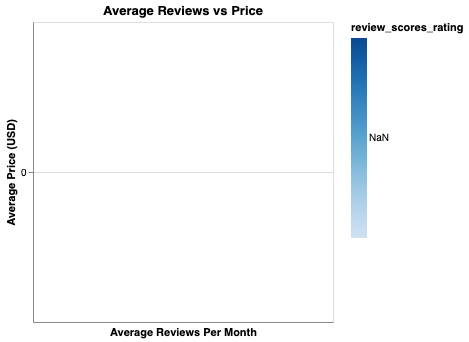

In [18]:
# Reviews correlation with pricing
reviews_bar = alt.Chart(df_cleaned).mark_bar().encode(
    x=alt.X("reviews_per_month", title="Average Reviews Per Month", bin=alt.BinParams(maxbins=20)),
    y=alt.Y("mean(price):Q", title="Average Price (USD)"),
    color="review_scores_rating:Q"
).properties(title="Average Reviews vs Price")

reviews_bar

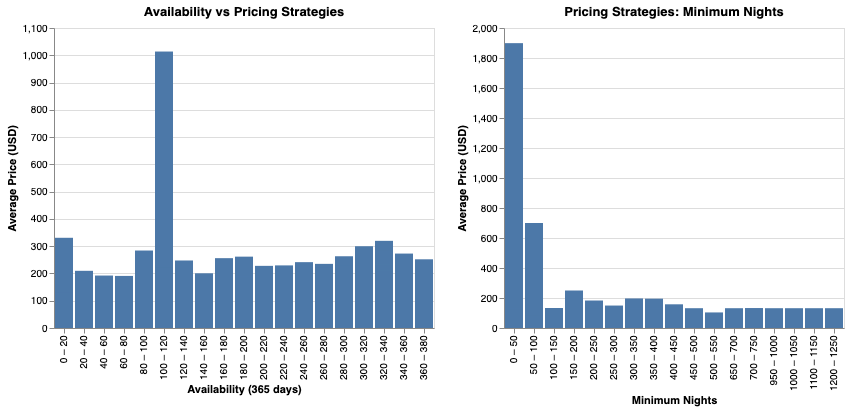

In [21]:
availability_bar = alt.Chart(df_cleaned).mark_bar().encode(
    x=alt.X("availability_365:O", title="Availability (365 days)", bin=alt.BinParams(maxbins=20)),
    y=alt.Y("mean(price):Q", title="Average Price (USD)"),
    tooltip=["availability_365", "mean(price)"]
).properties(title="Availability vs Pricing Strategies")

availability_chart = alt.Chart(df_cleaned).mark_bar().encode(
    x=alt.X("minimum_nights:O", title="Minimum Nights", bin=alt.BinParams(maxbins=30)),
    y=alt.Y("mean(price):Q", title="Average Price (USD)"),
    tooltip=["minimum_nights", "mean(price):Q"]
).properties(title="Pricing Strategies: Minimum Nights")

availability_bar | availability_chart